In [1]:
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Input, Flatten, Dense, Dropout, Lambda, MaxPooling2D, Conv2D, BatchNormalization
from tensorflow.keras.optimizers import RMSprop,Adam
from tensorflow.python.keras.callbacks import EarlyStopping,CSVLogger
from tensorflow.keras import backend as K
import tensorflow as tf
import pickle
from matplotlib import pyplot as plt
import numpy as np
from equation_as2 import equation

C:\Users\tashi\Anaconda3\lib\site-packages\tensorflow\python\framework\dtypes.py:516: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_qint8 = np.dtype([("qint8", np.int8, 1)])
C:\Users\tashi\Anaconda3\lib\site-packages\tensorflow\python\framework\dtypes.py:517: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_quint8 = np.dtype([("quint8", np.uint8, 1)])
C:\Users\tashi\Anaconda3\lib\site-packages\tensorflow\python\framework\dtypes.py:518: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_qint16 = np.dtype([("qint16", np.int16, 1)])
C:\Users\tashi\Anaconda3\lib\site-packages\tensorflow\python\framework\dtypes.py:519: FutureWarning: Passi

In [2]:
# add to the top of your code under import tensorflow as tf
config = tf.ConfigProto()
config.gpu_options.allow_growth = True
session = tf.Session(config=config)

In [3]:
train_x = pickle.load(open('./Data/train_pairs.pickle','rb'))
train_y = pickle.load(open('./Data/train_y.pickle','rb'))
test_x1 = pickle.load(open('./Data/test_pairs1.pickle','rb'))
test_y1 = pickle.load(open('./Data/test_y1.pickle','rb'))
test_x2 = pickle.load(open('./Data/test_pairs2.pickle','rb'))
test_y2 = pickle.load(open('./Data/test_y2.pickle','rb'))
test_x3 = pickle.load(open('./Data/test_pairs3.pickle','rb'))
test_y3 = pickle.load(open('./Data/test_y3.pickle','rb'))

In [4]:
train_x = train_x.astype('float32')
test_x1 = test_x1.astype('float32')
test_x2 = test_x2.astype('float32')
test_x3 = test_x3.astype('float32')
train_x /= 255
test_x1 /= 255
test_x2 /= 255
test_x3 /= 255

### define margin

In [5]:
Ass2_Equation = equation(0.7)

In [6]:
img_rows, img_cols = train_x.shape[2:4]
train_x = train_x.reshape(train_x.shape[0], 2 ,img_rows, img_cols, 1)
test_x1 = test_x1.reshape(test_x1.shape[0],2, img_rows, img_cols, 1)
test_x2 = test_x2.reshape(test_x2.shape[0],2, img_rows, img_cols, 1)
test_x3 = test_x3.reshape(test_x3.shape[0],2, img_rows, img_cols, 1)
input_shape = (img_rows, img_cols, 1)

In [7]:
def create_base_network(input_shape):
    '''Base network to be shared (eq. to feature extraction).
    '''
    input_tensor = Input(shape=input_shape)
    x = Conv2D(8, (3, 3), activation='relu',name='block1_conv1')(input_tensor)
    x = Conv2D(16, (3, 3), activation='relu',name='block1_conv2')(x)
    x = BatchNormalization()(x)
    x = MaxPooling2D(pool_size=(2, 2),name = 'block1_pool')(x)
    x = Conv2D(32, (3, 3), activation='relu',name='block2_conv1')(x)
    x = Conv2D(64, (3, 3), activation='relu',name='block3_conv1')(x)
    x = BatchNormalization()(x)    
    x = MaxPooling2D(pool_size=(2, 2),name = 'block3_pool')(x)
    x = Flatten()(x)
    output = Dense(128, activation='relu',name = 'embeding')(x) 
    
    return Model(input_tensor, output)

In [8]:
base_network = create_base_network(input_shape)
base_network.summary()
input_a = Input(shape=input_shape)
input_b = Input(shape=input_shape)
# because we re-use the same instance `base_network`,
# the weights of the network
# will be shared across the two branches
processed_a = base_network(input_a)
processed_b = base_network(input_b)

distance = Lambda(equation.euclidean_distance,
                  output_shape=equation.eucl_dist_output_shape)([processed_a, processed_b])

model = Model([input_a, input_b], distance)
model.summary()

W1011 21:23:13.113310  1504 deprecation.py:506] From C:\Users\tashi\Anaconda3\lib\site-packages\tensorflow\python\ops\init_ops.py:1251: calling VarianceScaling.__init__ (from tensorflow.python.ops.init_ops) with dtype is deprecated and will be removed in a future version.
Instructions for updating:
Call initializer instance with the dtype argument instead of passing it to the constructor


Model: "model"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         [(None, 28, 28, 1)]       0         
_________________________________________________________________
block1_conv1 (Conv2D)        (None, 26, 26, 8)         80        
_________________________________________________________________
block1_conv2 (Conv2D)        (None, 24, 24, 16)        1168      
_________________________________________________________________
batch_normalization (BatchNo (None, 24, 24, 16)        64        
_________________________________________________________________
block1_pool (MaxPooling2D)   (None, 12, 12, 16)        0         
_________________________________________________________________
block2_conv1 (Conv2D)        (None, 10, 10, 32)        4640      
_________________________________________________________________
block3_conv1 (Conv2D)        (None, 8, 8, 64)          18496 

W1006 12:07:08.604013  9076 deprecation.py:323] From C:\Users\tashi\Anaconda3\lib\site-packages\tensorflow\python\ops\math_grad.py:1250: add_dispatch_support.<locals>.wrapper (from tensorflow.python.ops.array_ops) is deprecated and will be removed in a future version.
Instructions for updating:
Use tf.where in 2.0, which has the same broadcast rule as np.where


Train on 60145 samples, validate on 6683 samples
Epoch 1/200
60145/60145 [==============================] - 9s 143us/sample - loss: 4.7980 - accuracy: 0.5056 - val_loss: 0.2789 - val_accuracy: 0.4567
Epoch 2/200
60145/60145 [==============================] - 7s 110us/sample - loss: 0.2283 - accuracy: 0.5067 - val_loss: 0.2974 - val_accuracy: 0.4297
Epoch 3/200
60145/60145 [==============================] - 7s 110us/sample - loss: 0.2104 - accuracy: 0.5107 - val_loss: 0.3005 - val_accuracy: 0.4154
Epoch 4/200
60145/60145 [==============================] - 7s 110us/sample - loss: 0.1992 - accuracy: 0.5163 - val_loss: 0.3430 - val_accuracy: 0.4198
Epoch 5/200
60145/60145 [==============================] - 7s 110us/sample - loss: 0.1872 - accuracy: 0.5443 - val_loss: 0.3280 - val_accuracy: 0.5754
Epoch 6/200
60145/60145 [==============================] - 7s 110us/sample - loss: 0.1741 - accuracy: 0.5746 - val_loss: 0.2618 - val_accuracy: 0.6576
Epoch 7/200
60145/60145 [====================

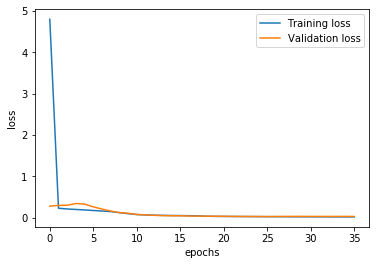

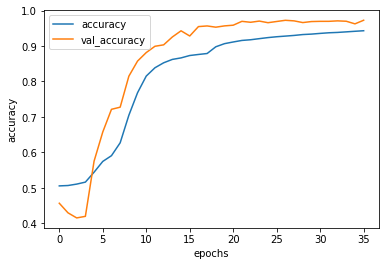

In [9]:
model_name='lr1e-4'
# train
epochs = 200
adam = Adam(learning_rate=1e-4,decay=1e-6/epochs)
model.compile(loss=Ass2_Equation.contrastive_loss, optimizer=adam, metrics=[equation.accuracy])

early_stopping_callback = EarlyStopping(monitor='val_loss', patience=10)
csv_logger = CSVLogger('./Data/Model'+model_name+'.log')
history = model.fit([train_x[:, 0], train_x[:, 1]], train_y,
          batch_size=128,
          epochs=epochs,
          validation_split=0.1,
          callbacks=[early_stopping_callback,csv_logger])

loss = history.history['loss'].copy()
val_loss= history.history['val_loss'].copy()
plt.plot(loss)
plt.plot(val_loss)
plt.legend(['Training loss','Validation loss'])
plt.xlabel("epochs")
plt.ylabel("loss")
plt.show()
accuracy = history.history['accuracy'].copy()
val_accuracy = history.history['val_accuracy'].copy()
plt.plot(accuracy)
plt.plot(val_accuracy)
plt.legend(['accuracy','val_accuracy'])
plt.xlabel("epochs")
plt.ylabel("accuracy")
plt.show()



In [20]:
pred1 = model.predict([test_x1[:,0],test_x1[:,1]])
pred2 = model.predict([test_x2[:,0],test_x2[:,1]])
pred3 = model.predict([test_x3[:,0],test_x3[:,1]])

te_acc1 = equation.compute_accuracy(test_y1, pred1)
te_acc2 = equation.compute_accuracy(test_y2, pred2)
te_acc3 = equation.compute_accuracy(test_y3, pred3)
print('* Accuracy on test1 set: %0.2f%%' % (100 * te_acc1))
print('* Accuracy on test2 set: %0.2f%%' % (100 * te_acc2))
print('* Accuracy on test3 set: %0.2f%%' % (100 * te_acc3))

model.save('./Data/model'+model_name+'.h5')

* Accuracy on test1 set: 92.09%
* Accuracy on test2 set: 70.12%
* Accuracy on test3 set: 80.84%


In [21]:
test_y2

array([1, 0, 1, ..., 0, 1, 0])

In [22]:
pred2

array([[0.3863511 ],
       [1.6235265 ],
       [1.1921101 ],
       ...,
       [1.4113997 ],
       [0.44761395],
       [0.00811791]], dtype=float32)

Model: "model_4"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_7 (InputLayer)         [(None, 28, 28, 1)]       0         
_________________________________________________________________
block1_conv1 (Conv2D)        (None, 26, 26, 8)         80        
_________________________________________________________________
block1_conv2 (Conv2D)        (None, 24, 24, 16)        1168      
_________________________________________________________________
batch_normalization_4 (Batch (None, 24, 24, 16)        64        
_________________________________________________________________
block1_pool (MaxPooling2D)   (None, 12, 12, 16)        0         
_________________________________________________________________
block2_conv1 (Conv2D)        (None, 10, 10, 32)        4640      
_________________________________________________________________
block3_conv1 (Conv2D)        (None, 8, 8, 64)          1849

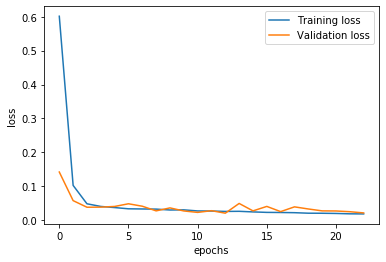

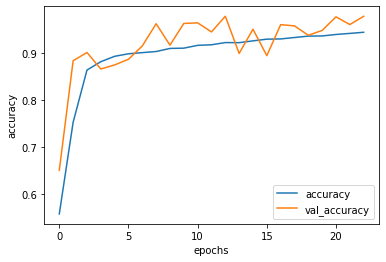

TypeError: compute_accuracy() takes 2 positional arguments but 3 were given

In [23]:
base_network = create_base_network(input_shape)
base_network.summary()
input_a = Input(shape=input_shape)
input_b = Input(shape=input_shape)
# because we re-use the same instance `base_network`,
# the weights of the network
# will be shared across the two branches
processed_a = base_network(input_a)
processed_b = base_network(input_b)

distance = Lambda(equation.euclidean_distance,
                  output_shape=equation.eucl_dist_output_shape)([processed_a, processed_b])

model = Model([input_a, input_b], distance)
model.summary()


model_name='lr1e-3'
# train
epochs = 200
adam = Adam(learning_rate=1e-3,decay=1e-6/epochs)
model.compile(loss=Ass2_Equation.contrastive_loss, optimizer=adam, metrics=[equation.accuracy])

early_stopping_callback = EarlyStopping(monitor='val_loss', patience=10)
csv_logger = CSVLogger('./Data/Model'+model_name+'.log')
history = model.fit([train_x[:, 0], train_x[:, 1]], train_y,
          batch_size=128,
          epochs=epochs,
          validation_split=0.1,
          callbacks=[early_stopping_callback,csv_logger])

loss = history.history['loss'].copy()
val_loss= history.history['val_loss'].copy()
plt.plot(loss)
plt.plot(val_loss)
plt.legend(['Training loss','Validation loss'])
plt.xlabel("epochs")
plt.ylabel("loss")
plt.show()
accuracy = history.history['accuracy'].copy()
val_accuracy = history.history['val_accuracy'].copy()
plt.plot(accuracy)
plt.plot(val_accuracy)
plt.legend(['accuracy','val_accuracy'])
plt.xlabel("epochs")
plt.ylabel("accuracy")
plt.show()

pred1 = model.predict([test_x1[:,0],test_x1[:,1]])
pred2 = model.predict([test_x2[:,0],test_x2[:,1]])
pred3 = model.predict([test_x3[:,0],test_x3[:,1]])



In [24]:
te_acc1 = equation.compute_accuracy(test_y1, pred1)
te_acc2 = equation.compute_accuracy(test_y2, pred2)
te_acc3 = equation.compute_accuracy(test_y3, pred3)
print('* Accuracy on test1 set: %0.2f%%' % (100 * te_acc1))
print('* Accuracy on test2 set: %0.2f%%' % (100 * te_acc2))
print('* Accuracy on test3 set: %0.2f%%' % (100 * te_acc3))

model.save('./Data/model'+model_name+'.h5')

* Accuracy on test1 set: 93.69%
* Accuracy on test2 set: 69.18%
* Accuracy on test3 set: 81.23%


leaky_RELU

In [31]:
def create_base_network2(input_shape):
    '''Base network to be shared (eq. to feature extraction).
    '''
    input_tensor = Input(shape=input_shape)
    x = Conv2D(8, (3, 3), activation=tf.nn.leaky_relu,name='block1_conv1')(input_tensor)
    x = Conv2D(16, (3, 3), activation=tf.nn.leaky_relu,name='block1_conv2')(x)
    x = BatchNormalization()(x)
    x = MaxPooling2D(pool_size=(2, 2),name = 'block1_pool')(x)
    x = Conv2D(32, (3, 3), activation=tf.nn.leaky_relu,name='block2_conv1')(x)
    x = Conv2D(64, (3, 3), activation=tf.nn.leaky_relu,name='block3_conv1')(x)
    x = BatchNormalization()(x)    
    x = MaxPooling2D(pool_size=(2, 2),name = 'block3_pool')(x)
    x = Flatten()(x)
    output = Dense(128, activation=tf.nn.leaky_relu ,name = 'embeding')(x) 
    
    return Model(input_tensor, output)

Model: "model_6"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_13 (InputLayer)        [(None, 28, 28, 1)]       0         
_________________________________________________________________
block1_conv1 (Conv2D)        (None, 26, 26, 8)         80        
_________________________________________________________________
block1_conv2 (Conv2D)        (None, 24, 24, 16)        1168      
_________________________________________________________________
batch_normalization_6 (Batch (None, 24, 24, 16)        64        
_________________________________________________________________
block1_pool (MaxPooling2D)   (None, 12, 12, 16)        0         
_________________________________________________________________
block2_conv1 (Conv2D)        (None, 10, 10, 32)        4640      
_________________________________________________________________
block3_conv1 (Conv2D)        (None, 8, 8, 64)          1849

60145/60145 [==============================] - 7s 120us/sample - loss: 0.0309 - accuracy: 0.9206 - val_loss: 0.0201 - val_accuracy: 0.9697
Epoch 34/200
60145/60145 [==============================] - 7s 120us/sample - loss: 0.0304 - accuracy: 0.9217 - val_loss: 0.0200 - val_accuracy: 0.9694
Epoch 35/200
60145/60145 [==============================] - 7s 120us/sample - loss: 0.0297 - accuracy: 0.9231 - val_loss: 0.0193 - val_accuracy: 0.9543
Epoch 36/200
60145/60145 [==============================] - 7s 119us/sample - loss: 0.0294 - accuracy: 0.9242 - val_loss: 0.0188 - val_accuracy: 0.9679
Epoch 37/200
60145/60145 [==============================] - 7s 120us/sample - loss: 0.0294 - accuracy: 0.9245 - val_loss: 0.0188 - val_accuracy: 0.9363
Epoch 38/200
60145/60145 [==============================] - 7s 120us/sample - loss: 0.0290 - accuracy: 0.9252 - val_loss: 0.0176 - val_accuracy: 0.9602
Epoch 39/200
60145/60145 [==============================] - 7s 121us/sample - loss: 0.0285 - accuracy

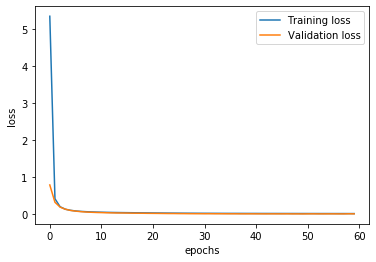

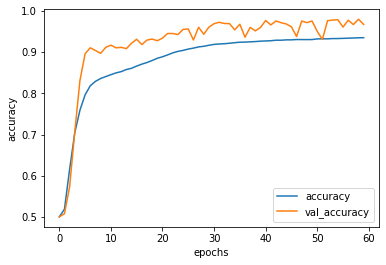

* Accuracy on test1 set: 93.93%
* Accuracy on test2 set: 73.04%
* Accuracy on test3 set: 82.98%


In [32]:
base_network = create_base_network2(input_shape)
base_network.summary()
input_a = Input(shape=input_shape)
input_b = Input(shape=input_shape)
# because we re-use the same instance `base_network`,
# the weights of the network
# will be shared across the two branches
processed_a = base_network(input_a)
processed_b = base_network(input_b)

distance = Lambda(equation.euclidean_distance,
                  output_shape=equation.eucl_dist_output_shape)([processed_a, processed_b])

model = Model([input_a, input_b], distance)
model.summary()


model_name='leaky_relu_lr1e-4'
# train
epochs = 200
adam = Adam(learning_rate=1e-4,decay=1e-6/epochs)
model.compile(loss=Ass2_Equation.contrastive_loss, optimizer=adam, metrics=[equation.accuracy])

early_stopping_callback = EarlyStopping(monitor='val_loss', patience=10)
csv_logger = CSVLogger('./Data/Model'+model_name+'.log')
history = model.fit([train_x[:, 0], train_x[:, 1]], train_y,
          batch_size=128,
          epochs=epochs,
          validation_split=0.1,
          callbacks=[early_stopping_callback,csv_logger])

loss = history.history['loss'].copy()
val_loss= history.history['val_loss'].copy()
plt.plot(loss)
plt.plot(val_loss)
plt.legend(['Training loss','Validation loss'])
plt.xlabel("epochs")
plt.ylabel("loss")
plt.show()
accuracy = history.history['accuracy'].copy()
val_accuracy = history.history['val_accuracy'].copy()
plt.plot(accuracy)
plt.plot(val_accuracy)
plt.legend(['accuracy','val_accuracy'])
plt.xlabel("epochs")
plt.ylabel("accuracy")
plt.show()

pred1 = model.predict([test_x1[:,0],test_x1[:,1]])
pred2 = model.predict([test_x2[:,0],test_x2[:,1]])
pred3 = model.predict([test_x3[:,0],test_x3[:,1]])

te_acc1 = equation.compute_accuracy(test_y1, pred1)
te_acc2 = equation.compute_accuracy(test_y2, pred2)
te_acc3 = equation.compute_accuracy(test_y3, pred3)
print('* Accuracy on test1 set: %0.2f%%' % (100 * te_acc1))
print('* Accuracy on test2 set: %0.2f%%' % (100 * te_acc2))
print('* Accuracy on test3 set: %0.2f%%' % (100 * te_acc3))

model.save('./Data/model'+model_name+'.h5')

Model: "model_8"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_16 (InputLayer)        [(None, 28, 28, 1)]       0         
_________________________________________________________________
block1_conv1 (Conv2D)        (None, 26, 26, 8)         80        
_________________________________________________________________
block1_conv2 (Conv2D)        (None, 24, 24, 16)        1168      
_________________________________________________________________
batch_normalization_8 (Batch (None, 24, 24, 16)        64        
_________________________________________________________________
block1_pool (MaxPooling2D)   (None, 12, 12, 16)        0         
_________________________________________________________________
block2_conv1 (Conv2D)        (None, 10, 10, 32)        4640      
_________________________________________________________________
block3_conv1 (Conv2D)        (None, 8, 8, 64)          1849

60145/60145 [==============================] - 7s 121us/sample - loss: 0.0191 - accuracy: 0.9485 - val_loss: 0.0113 - val_accuracy: 0.9882
Epoch 34/200
60145/60145 [==============================] - 7s 121us/sample - loss: 0.0186 - accuracy: 0.9500 - val_loss: 0.0139 - val_accuracy: 0.9849
Epoch 35/200
60145/60145 [==============================] - 7s 121us/sample - loss: 0.0182 - accuracy: 0.9511 - val_loss: 0.0141 - val_accuracy: 0.9868
Epoch 36/200
60145/60145 [==============================] - 7s 121us/sample - loss: 0.0176 - accuracy: 0.9518 - val_loss: 0.0132 - val_accuracy: 0.9770
Epoch 37/200
60145/60145 [==============================] - 7s 121us/sample - loss: 0.0173 - accuracy: 0.9529 - val_loss: 0.0126 - val_accuracy: 0.9829
Epoch 38/200
60145/60145 [==============================] - 7s 122us/sample - loss: 0.0169 - accuracy: 0.9542 - val_loss: 0.0112 - val_accuracy: 0.9885s: 0.0168 -  - ETA: 0s -
Epoch 39/200
60145/60145 [==============================] - 7s 122us/sample -

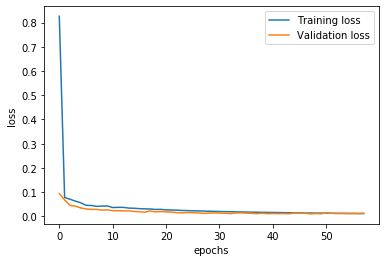

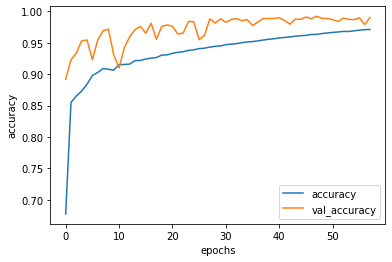

* Accuracy on test1 set: 95.82%
* Accuracy on test2 set: 71.14%
* Accuracy on test3 set: 83.75%


In [33]:
base_network = create_base_network2(input_shape)
base_network.summary()
input_a = Input(shape=input_shape)
input_b = Input(shape=input_shape)
# because we re-use the same instance `base_network`,
# the weights of the network
# will be shared across the two branches
processed_a = base_network(input_a)
processed_b = base_network(input_b)

distance = Lambda(equation.euclidean_distance,
                  output_shape=equation.eucl_dist_output_shape)([processed_a, processed_b])

model = Model([input_a, input_b], distance)
model.summary()


model_name='leaky_relu_lr1e-3'
# train
epochs = 200
adam = Adam(learning_rate=1e-3,decay=1e-6/epochs)
model.compile(loss=Ass2_Equation.contrastive_loss, optimizer=adam, metrics=[equation.accuracy])

early_stopping_callback = EarlyStopping(monitor='val_loss', patience=10)
csv_logger = CSVLogger('./Data/Model'+model_name+'.log')
history = model.fit([train_x[:, 0], train_x[:, 1]], train_y,
          batch_size=128,
          epochs=epochs,
          validation_split=0.1,
          callbacks=[early_stopping_callback,csv_logger])

loss = history.history['loss'].copy()
val_loss= history.history['val_loss'].copy()
plt.plot(loss)
plt.plot(val_loss)
plt.legend(['Training loss','Validation loss'])
plt.xlabel("epochs")
plt.ylabel("loss")
plt.show()
accuracy = history.history['accuracy'].copy()
val_accuracy = history.history['val_accuracy'].copy()
plt.plot(accuracy)
plt.plot(val_accuracy)
plt.legend(['accuracy','val_accuracy'])
plt.xlabel("epochs")
plt.ylabel("accuracy")
plt.show()

pred1 = model.predict([test_x1[:,0],test_x1[:,1]])
pred2 = model.predict([test_x2[:,0],test_x2[:,1]])
pred3 = model.predict([test_x3[:,0],test_x3[:,1]])

te_acc1 = equation.compute_accuracy(test_y1, pred1)
te_acc2 = equation.compute_accuracy(test_y2, pred2)
te_acc3 = equation.compute_accuracy(test_y3, pred3)
print('* Accuracy on test1 set: %0.2f%%' % (100 * te_acc1))
print('* Accuracy on test2 set: %0.2f%%' % (100 * te_acc2))
print('* Accuracy on test3 set: %0.2f%%' % (100 * te_acc3))

model.save('./Data/model'+model_name+'.h5')

In [37]:
def create_base_network2(input_shape):
    '''Base network to be shared (eq. to feature extraction).
    '''
    input_tensor = Input(shape=input_shape)
    x = Conv2D(8, (3, 3), activation=tf.nn.leaky_relu,name='block1_conv1')(input_tensor)
    x = Conv2D(16, (3, 3), activation=tf.nn.leaky_relu,name='block1_conv2')(x)
    x = BatchNormalization()(x)
    x = MaxPooling2D(pool_size=(2, 2),name = 'block1_pool')(x)
    x = Conv2D(32, (3, 3), activation=tf.nn.leaky_relu,name='block2_conv1')(x)
    x = Conv2D(64, (3, 3), activation=tf.nn.leaky_relu,name='block3_conv1')(x)
    x = BatchNormalization()(x)    
    x = MaxPooling2D(pool_size=(2, 2),name = 'block3_pool')(x)
    x = Dropout(0.2)(x)
    x = Flatten()(x)
    output = Dense(128, activation=tf.nn.leaky_relu ,name = 'embeding')(x) 
    
    return Model(input_tensor, output)

In [38]:
base_network = create_base_network2(input_shape)
base_network.summary()
input_a = Input(shape=input_shape)
input_b = Input(shape=input_shape)
# because we re-use the same instance `base_network`,
# the weights of the network
# will be shared across the two branches
processed_a = base_network(input_a)
processed_b = base_network(input_b)

distance = Lambda(equation.euclidean_distance,
                  output_shape=equation.eucl_dist_output_shape)([processed_a, processed_b])

model = Model([input_a, input_b], distance)
model.summary()

Model: "model_12"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_22 (InputLayer)        [(None, 28, 28, 1)]       0         
_________________________________________________________________
block1_conv1 (Conv2D)        (None, 26, 26, 8)         80        
_________________________________________________________________
block1_conv2 (Conv2D)        (None, 24, 24, 16)        1168      
_________________________________________________________________
batch_normalization_12 (Batc (None, 24, 24, 16)        64        
_________________________________________________________________
block1_pool (MaxPooling2D)   (None, 12, 12, 16)        0         
_________________________________________________________________
block2_conv1 (Conv2D)        (None, 10, 10, 32)        4640      
_________________________________________________________________
block3_conv1 (Conv2D)        (None, 8, 8, 64)          184

Train on 60145 samples, validate on 6683 samples
Epoch 1/200
60145/60145 [==============================] - 8s 139us/sample - loss: 3.0865 - accuracy: 0.5000 - val_loss: 0.1202 - val_accuracy: 0.8022
Epoch 2/200
60145/60145 [==============================] - 7s 124us/sample - loss: 0.6941 - accuracy: 0.5000 - val_loss: 0.0661 - val_accuracy: 0.8362
Epoch 3/200
60145/60145 [==============================] - 8s 125us/sample - loss: 0.2515 - accuracy: 0.5509 - val_loss: 0.0636 - val_accuracy: 0.6690
Epoch 4/200
60145/60145 [==============================] - 7s 125us/sample - loss: 0.1182 - accuracy: 0.7617 - val_loss: 0.0384 - val_accuracy: 0.8883
Epoch 5/200
60145/60145 [==============================] - 7s 123us/sample - loss: 0.0752 - accuracy: 0.8550 - val_loss: 0.0301 - val_accuracy: 0.8962
Epoch 6/200
60145/60145 [==============================] - 7s 123us/sample - loss: 0.0584 - accuracy: 0.8803 - val_loss: 0.0278 - val_accuracy: 0.8990
Epoch 7/200
60145/60145 [====================

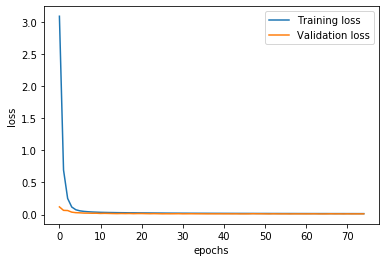

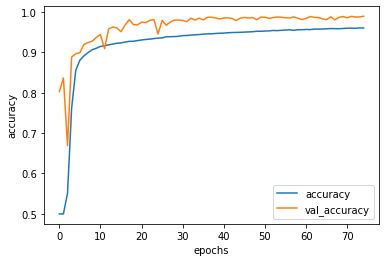

* Accuracy on test1 set: 95.48%
* Accuracy on test2 set: 70.76%
* Accuracy on test3 set: 83.42%


In [39]:
model_name='leaky_relu_lr1e-3_dropout'
# train
epochs = 200
adam = Adam(learning_rate=1e-3,decay=1e-6/epochs)
model.compile(loss=Ass2_Equation.contrastive_loss, optimizer=adam, metrics=[equation.accuracy])

early_stopping_callback = EarlyStopping(monitor='val_loss', patience=10)
csv_logger = CSVLogger('./Data/Model'+model_name+'.log')
history = model.fit([train_x[:, 0], train_x[:, 1]], train_y,
          batch_size=128,
          epochs=epochs,
          validation_split=0.1,
          callbacks=[early_stopping_callback,csv_logger])

loss = history.history['loss'].copy()
val_loss= history.history['val_loss'].copy()
plt.plot(loss)
plt.plot(val_loss)
plt.legend(['Training loss','Validation loss'])
plt.xlabel("epochs")
plt.ylabel("loss")
plt.show()
accuracy = history.history['accuracy'].copy()
val_accuracy = history.history['val_accuracy'].copy()
plt.plot(accuracy)
plt.plot(val_accuracy)
plt.legend(['accuracy','val_accuracy'])
plt.xlabel("epochs")
plt.ylabel("accuracy")
plt.show()

pred1 = model.predict([test_x1[:,0],test_x1[:,1]])
pred2 = model.predict([test_x2[:,0],test_x2[:,1]])
pred3 = model.predict([test_x3[:,0],test_x3[:,1]])

te_acc1 = equation.compute_accuracy(test_y1, pred1)
te_acc2 = equation.compute_accuracy(test_y2, pred2)
te_acc3 = equation.compute_accuracy(test_y3, pred3)
print('* Accuracy on test1 set: %0.2f%%' % (100 * te_acc1))
print('* Accuracy on test2 set: %0.2f%%' % (100 * te_acc2))
print('* Accuracy on test3 set: %0.2f%%' % (100 * te_acc3))

model.save('./Data/model'+model_name+'.h5')

In [42]:
def create_base_network2(input_shape):
    '''Base network to be shared (eq. to feature extraction).
    '''
    input_tensor = Input(shape=input_shape)
    x = Conv2D(8, (3, 3), activation=tf.nn.leaky_relu,name='block1_conv1')(input_tensor)
    x = Conv2D(16, (3, 3), activation=tf.nn.leaky_relu,name='block1_conv2')(x)
    x = BatchNormalization()(x)
    x = MaxPooling2D(pool_size=(2, 2),name = 'block1_pool')(x)
    x = Conv2D(32, (3, 3), activation=tf.nn.leaky_relu,name='block2_conv1')(x)
    x = Conv2D(64, (3, 3), activation=tf.nn.leaky_relu,name='block3_conv1')(x)
    x = BatchNormalization()(x)    
    x = MaxPooling2D(pool_size=(2, 2),name = 'block3_pool')(x)
    x = Flatten()(x)
    x = Dropout(0.2)(x)
    output = Dense(128, activation=tf.nn.leaky_relu ,name = 'embeding')(x) 
    
    return Model(input_tensor, output)

In [43]:
base_network = create_base_network2(input_shape)
base_network.summary()
input_a = Input(shape=input_shape)
input_b = Input(shape=input_shape)
# because we re-use the same instance `base_network`,
# the weights of the network
# will be shared across the two branches
processed_a = base_network(input_a)
processed_b = base_network(input_b)

distance = Lambda(equation.euclidean_distance,
                  output_shape=equation.eucl_dist_output_shape)([processed_a, processed_b])

model = Model([input_a, input_b], distance)
model.summary()

Model: "model_14"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_25 (InputLayer)        [(None, 28, 28, 1)]       0         
_________________________________________________________________
block1_conv1 (Conv2D)        (None, 26, 26, 8)         80        
_________________________________________________________________
block1_conv2 (Conv2D)        (None, 24, 24, 16)        1168      
_________________________________________________________________
batch_normalization_14 (Batc (None, 24, 24, 16)        64        
_________________________________________________________________
block1_pool (MaxPooling2D)   (None, 12, 12, 16)        0         
_________________________________________________________________
block2_conv1 (Conv2D)        (None, 10, 10, 32)        4640      
_________________________________________________________________
block3_conv1 (Conv2D)        (None, 8, 8, 64)          184

Train on 60145 samples, validate on 6683 samples
Epoch 1/200
60145/60145 [==============================] - 8s 140us/sample - loss: 2.9885 - accuracy: 0.5000 - val_loss: 0.1016 - val_accuracy: 0.8637
Epoch 2/200
60145/60145 [==============================] - 7s 124us/sample - loss: 0.5847 - accuracy: 0.5014 - val_loss: 0.0922 - val_accuracy: 0.5238
Epoch 3/200
60145/60145 [==============================] - 8s 125us/sample - loss: 0.2017 - accuracy: 0.6013 - val_loss: 0.0425 - val_accuracy: 0.8564
Epoch 4/200
60145/60145 [==============================] - 7s 121us/sample - loss: 0.0990 - accuracy: 0.7984 - val_loss: 0.0331 - val_accuracy: 0.8895
Epoch 5/200
60145/60145 [==============================] - 7s 120us/sample - loss: 0.0681 - accuracy: 0.8558 - val_loss: 0.0303 - val_accuracy: 0.8910
Epoch 6/200
60145/60145 [==============================] - 7s 123us/sample - loss: 0.0561 - accuracy: 0.8717 - val_loss: 0.0252 - val_accuracy: 0.9043
Epoch 7/200
60145/60145 [====================

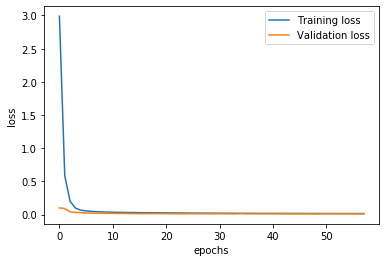

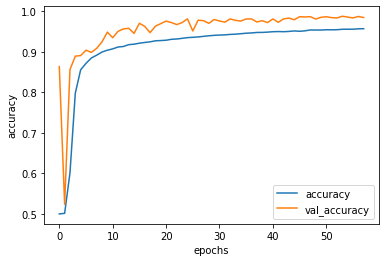

* Accuracy on test1 set: 95.18%
* Accuracy on test2 set: 71.78%
* Accuracy on test3 set: 83.67%


In [44]:
model_name='leaky_relu_lr1e-3_dropout_after_flat'
# train
epochs = 200
adam = Adam(learning_rate=1e-3,decay=1e-6/epochs)
model.compile(loss=Ass2_Equation.contrastive_loss, optimizer=adam, metrics=[equation.accuracy])

early_stopping_callback = EarlyStopping(monitor='val_loss', patience=10)
csv_logger = CSVLogger('./Data/Model'+model_name+'.log')
history = model.fit([train_x[:, 0], train_x[:, 1]], train_y,
          batch_size=128,
          epochs=epochs,
          validation_split=0.1,
          callbacks=[early_stopping_callback,csv_logger])

loss = history.history['loss'].copy()
val_loss= history.history['val_loss'].copy()
plt.plot(loss)
plt.plot(val_loss)
plt.legend(['Training loss','Validation loss'])
plt.xlabel("epochs")
plt.ylabel("loss")
plt.show()
accuracy = history.history['accuracy'].copy()
val_accuracy = history.history['val_accuracy'].copy()
plt.plot(accuracy)
plt.plot(val_accuracy)
plt.legend(['accuracy','val_accuracy'])
plt.xlabel("epochs")
plt.ylabel("accuracy")
plt.show()

pred1 = model.predict([test_x1[:,0],test_x1[:,1]])
pred2 = model.predict([test_x2[:,0],test_x2[:,1]])
pred3 = model.predict([test_x3[:,0],test_x3[:,1]])

te_acc1 = equation.compute_accuracy(test_y1, pred1)
te_acc2 = equation.compute_accuracy(test_y2, pred2)
te_acc3 = equation.compute_accuracy(test_y3, pred3)
print('* Accuracy on test1 set: %0.2f%%' % (100 * te_acc1))
print('* Accuracy on test2 set: %0.2f%%' % (100 * te_acc2))
print('* Accuracy on test3 set: %0.2f%%' % (100 * te_acc3))

model.save('./Data/model'+model_name+'.h5')

In [20]:
def create_base_network2(input_shape):
    '''Base network to be shared (eq. to feature extraction).
    '''
    input_tensor = Input(shape=input_shape)
    x = Conv2D(8, (3, 3), activation=tf.nn.elu,name='block1_conv1')(input_tensor)
    x = Conv2D(16, (3, 3), activation=tf.nn.elu,name='block1_conv2')(x)
    x = BatchNormalization()(x)
    x = MaxPooling2D(pool_size=(2, 2),name = 'block1_pool')(x)
    x = Conv2D(32, (3, 3), activation=tf.nn.elu,name='block2_conv1')(x)
    x = Conv2D(64, (3, 3), activation=tf.nn.elu,name='block3_conv1')(x)
    x = BatchNormalization()(x)    
    x = MaxPooling2D(pool_size=(2, 2),name = 'block3_pool')(x)
    x = Flatten()(x)
    x = Dropout(0.2)(x)
    output = Dense(128, activation=tf.nn.elu ,name = 'embeding')(x) 
    
    return Model(input_tensor, output)

In [21]:
base_network = create_base_network2(input_shape)
base_network.summary()
input_a = Input(shape=input_shape)
input_b = Input(shape=input_shape)
# because we re-use the same instance `base_network`,
# the weights of the network
# will be shared across the two branches
processed_a = base_network(input_a)
processed_b = base_network(input_b)

distance = Lambda(equation.euclidean_distance,
                  output_shape=equation.eucl_dist_output_shape)([processed_a, processed_b])

model = Model([input_a, input_b], distance)
model.summary()

Model: "model_2"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_4 (InputLayer)         [(None, 28, 28, 1)]       0         
_________________________________________________________________
block1_conv1 (Conv2D)        (None, 26, 26, 8)         80        
_________________________________________________________________
block1_conv2 (Conv2D)        (None, 24, 24, 16)        1168      
_________________________________________________________________
batch_normalization_2 (Batch (None, 24, 24, 16)        64        
_________________________________________________________________
block1_pool (MaxPooling2D)   (None, 12, 12, 16)        0         
_________________________________________________________________
block2_conv1 (Conv2D)        (None, 10, 10, 32)        4640      
_________________________________________________________________
block3_conv1 (Conv2D)        (None, 8, 8, 64)          1849

In [22]:
Ass2_Equation = equation(0.7)

Train on 60145 samples, validate on 6683 samples
Epoch 1/200
60145/60145 [==============================] - 7s 117us/sample - loss: 0.9308 - accuracy: 0.5266 - val_loss: 0.1351 - val_accuracy: 0.5012
Epoch 2/200
60145/60145 [==============================] - 6s 106us/sample - loss: 0.1191 - accuracy: 0.5531 - val_loss: 0.0934 - val_accuracy: 0.5277
Epoch 3/200
60145/60145 [==============================] - 6s 106us/sample - loss: 0.1095 - accuracy: 0.5800 - val_loss: 0.0886 - val_accuracy: 0.5193
Epoch 4/200
60145/60145 [==============================] - 6s 106us/sample - loss: 0.0951 - accuracy: 0.6452 - val_loss: 0.0560 - val_accuracy: 0.7608
Epoch 5/200
60145/60145 [==============================] - 6s 105us/sample - loss: 0.0716 - accuracy: 0.7561 - val_loss: 0.0533 - val_accuracy: 0.7155
Epoch 6/200
60145/60145 [==============================] - 6s 105us/sample - loss: 0.0562 - accuracy: 0.8171 - val_loss: 0.0359 - val_accuracy: 0.9059
Epoch 7/200
60145/60145 [====================

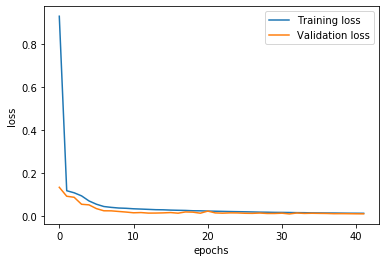

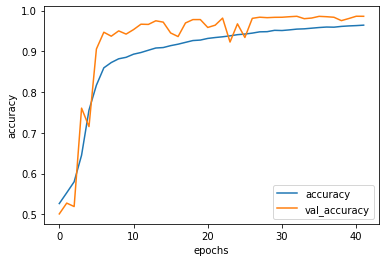

* Accuracy on test1 set: 95.59%
* Accuracy on test2 set: 70.03%
* Accuracy on test3 set: 82.67%


In [23]:
model_name='ELU_lr1e-3_dropout'
# train
epochs = 200
adam = Adam(learning_rate=1e-3,decay=1e-6/epochs)
model.compile(loss=Ass2_Equation.contrastive_loss, optimizer=adam, metrics=[equation.accuracy])

early_stopping_callback = EarlyStopping(monitor='val_loss', patience=10)
csv_logger = CSVLogger('./Data/Model'+model_name+'.log')
history = model.fit([train_x[:, 0], train_x[:, 1]], train_y,
          batch_size=128,
          epochs=epochs,
          validation_split=0.1,
          callbacks=[early_stopping_callback,csv_logger])

loss = history.history['loss'].copy()
val_loss= history.history['val_loss'].copy()
plt.plot(loss)
plt.plot(val_loss)
plt.legend(['Training loss','Validation loss'])
plt.xlabel("epochs")
plt.ylabel("loss")
plt.show()

accuracy = history.history['accuracy'].copy()
val_accuracy = history.history['val_accuracy'].copy()
plt.plot(accuracy)
plt.plot(val_accuracy)
plt.legend(['accuracy','val_accuracy'])
plt.xlabel("epochs")
plt.ylabel("accuracy")
plt.show()

pred1 = model.predict([test_x1[:,0],test_x1[:,1]])
pred2 = model.predict([test_x2[:,0],test_x2[:,1]])
pred3 = model.predict([test_x3[:,0],test_x3[:,1]])

te_acc1 = equation.compute_accuracy(test_y1, pred1)
te_acc2 = equation.compute_accuracy(test_y2, pred2)
te_acc3 = equation.compute_accuracy(test_y3, pred3)
print('* Accuracy on test1 set: %0.2f%%' % (100 * te_acc1))
print('* Accuracy on test2 set: %0.2f%%' % (100 * te_acc2))
print('* Accuracy on test3 set: %0.2f%%' % (100 * te_acc3))

model.save('./Data/model'+model_name+'.h5')

In [ ]:
* Accuracy on test1 set: 96.01%
* Accuracy on test2 set: 70.30%
* Accuracy on test3 set: 82.65%

In [26]:
# with margin as 1
Ass2_Equation = equation(1.0)

Train on 60145 samples, validate on 6683 samples
Epoch 1/200
60145/60145 [==============================] - 10s 159us/sample - loss: 0.0212 - accuracy: 0.9873 - val_loss: 0.0237 - val_accuracy: 0.9813
Epoch 2/200
60145/60145 [==============================] - 9s 155us/sample - loss: 0.0209 - accuracy: 0.9874 - val_loss: 0.0199 - val_accuracy: 0.9872
Epoch 3/200
60145/60145 [==============================] - 11s 190us/sample - loss: 0.0211 - accuracy: 0.9872 - val_loss: 0.0213 - val_accuracy: 0.9857
Epoch 4/200
60145/60145 [==============================] - 13s 208us/sample - loss: 0.0208 - accuracy: 0.9875 - val_loss: 0.0207 - val_accuracy: 0.9850
Epoch 5/200
60145/60145 [==============================] - 13s 214us/sample - loss: 0.0211 - accuracy: 0.9874 - val_loss: 0.0219 - val_accuracy: 0.9851
Epoch 6/200
60145/60145 [==============================] - 12s 202us/sample - loss: 0.0210 - accuracy: 0.9874 - val_loss: 0.0212 - val_accuracy: 0.9857
Epoch 7/200
60145/60145 [===============

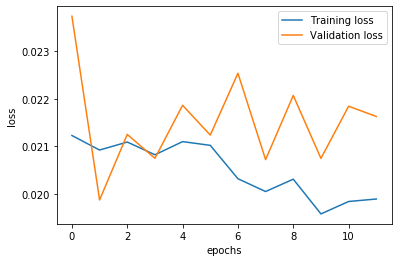

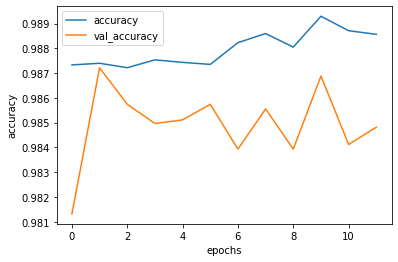

* Accuracy on test1 set: 95.92%
* Accuracy on test2 set: 66.55%
* Accuracy on test3 set: 81.82%


In [28]:

model_name='ELU_lr1e-3_dropout_margin1'
# train
epochs = 200
adam = Adam(learning_rate=1e-3,decay=1e-6/epochs)
model.compile(loss=Ass2_Equation.contrastive_loss, optimizer=adam, metrics=[equation.accuracy])

early_stopping_callback = EarlyStopping(monitor='val_loss', patience=10)
csv_logger = CSVLogger('./Data/Model'+model_name+'.log')
history = model.fit([train_x[:, 0], train_x[:, 1]], train_y,
          batch_size=128,
          epochs=epochs,
          validation_split=0.1,
          callbacks=[early_stopping_callback,csv_logger])

loss = history.history['loss'].copy()
val_loss= history.history['val_loss'].copy()
plt.plot(loss)
plt.plot(val_loss)
plt.legend(['Training loss','Validation loss'])
plt.xlabel("epochs")
plt.ylabel("loss")
plt.show()

accuracy = history.history['accuracy'].copy()
val_accuracy = history.history['val_accuracy'].copy()
plt.plot(accuracy)
plt.plot(val_accuracy)
plt.legend(['accuracy','val_accuracy'])
plt.xlabel("epochs")
plt.ylabel("accuracy")
plt.show()

pred1 = model.predict([test_x1[:,0],test_x1[:,1]])
pred2 = model.predict([test_x2[:,0],test_x2[:,1]])
pred3 = model.predict([test_x3[:,0],test_x3[:,1]])

te_acc1 = equation.compute_accuracy(test_y1, pred1)
te_acc2 = equation.compute_accuracy(test_y2, pred2)
te_acc3 = equation.compute_accuracy(test_y3, pred3)
print('* Accuracy on test1 set: %0.2f%%' % (100 * te_acc1))
print('* Accuracy on test2 set: %0.2f%%' % (100 * te_acc2))
print('* Accuracy on test3 set: %0.2f%%' % (100 * te_acc3))

model.save('./Data/model'+model_name+'.h5')

In [53]:
results = model.evaluate(test_features, test_labels)
for name, value in zip(model.metrics_names, results):
    print(name, ': ', value)

NameError: name 'labels' is not defined

In [ ]:
loss = history.history['loss'].copy()
val_loss= history.history['val_loss'].copy()
plt.plot(loss)
plt.plot(val_loss)
plt.legend(['Training loss','Validation loss'])
plt.xlabel("epochs")
plt.ylabel("loss")
plt.show()

accuracy = history.history['accuracy'].copy()
val_accuracy = history.history['val_accuracy'].copy()
plt.plot(accuracy)
plt.plot(val_accuracy)
plt.legend(['accuracy','val_accuracy'])
plt.xlabel("epochs")
plt.ylabel("accuracy")
plt.show()


In [75]:
fn = history.history[keras.metrics.TruePositives()].copy()

KeyError: <tensorflow.python.keras.metrics.TruePositives object at 0x00000253E6BFE5C8>

In [24]:
  metrics = [
    equation.accuracy,
     tf.metrics.precision(name='precision')
  ]

In [30]:
model_name='ELU_lr1e-3_dropout_auc'
# train
epochs = 200
adam = Adam(learning_rate=1e-3,decay=1e-6/epochs)
model.compile(loss=Ass2_Equation.contrastive_loss, optimizer=adam, metrics=[equation.accuracy])

Train on 60145 samples, validate on 6683 samples
Epoch 1/200
60145/60145 [==============================] - 7s 123us/sample - loss: 0.0621 - accuracy: 0.8357 - val_loss: 0.0500 - val_accuracy: 0.8422
Epoch 2/200
60145/60145 [==============================] - 7s 112us/sample - loss: 0.0472 - accuracy: 0.8609 - val_loss: 0.0279 - val_accuracy: 0.8798
Epoch 3/200
60145/60145 [==============================] - 7s 113us/sample - loss: 0.0413 - accuracy: 0.8727 - val_loss: 0.0268 - val_accuracy: 0.9117
Epoch 4/200
60145/60145 [==============================] - 7s 112us/sample - loss: 0.0387 - accuracy: 0.8807 - val_loss: 0.0288 - val_accuracy: 0.8464
Epoch 5/200
60145/60145 [==============================] - 7s 113us/sample - loss: 0.0367 - accuracy: 0.8843 - val_loss: 0.0337 - val_accuracy: 0.8488
Epoch 6/200
60145/60145 [==============================] - 7s 112us/sample - loss: 0.0343 - accuracy: 0.8920 - val_loss: 0.0251 - val_accuracy: 0.8878
Epoch 7/200
60145/60145 [====================

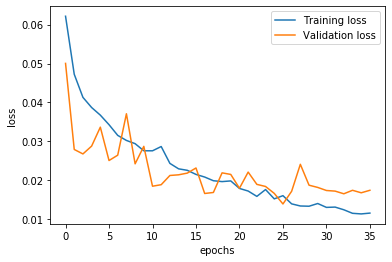

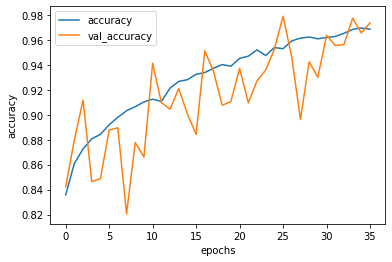

* Accuracy on test1 set: 93.43%
* Accuracy on test2 set: 68.59%
* Accuracy on test3 set: 80.89%


In [31]:

early_stopping_callback = EarlyStopping(monitor='val_loss', patience=10)
csv_logger = CSVLogger('./Data/Model'+model_name+'.log')
history = model.fit([train_x[:, 0], train_x[:, 1]], train_y,
          batch_size=128,
          epochs=epochs,
          validation_split=0.1,
          callbacks=[early_stopping_callback, csv_logger])

loss = history.history['loss'].copy()
val_loss= history.history['val_loss'].copy()
plt.plot(loss)
plt.plot(val_loss)
plt.legend(['Training loss','Validation loss'])
plt.xlabel("epochs")
plt.ylabel("loss")
plt.show()

accuracy = history.history['accuracy'].copy()
val_accuracy = history.history['val_accuracy'].copy()
plt.plot(accuracy)
plt.plot(val_accuracy)
plt.legend(['accuracy','val_accuracy'])
plt.xlabel("epochs")
plt.ylabel("accuracy")
plt.show()

pred1 = model.predict([test_x1[:,0],test_x1[:,1]])
pred2 = model.predict([test_x2[:,0],test_x2[:,1]])
pred3 = model.predict([test_x3[:,0],test_x3[:,1]])

te_acc1 = equation.compute_accuracy(test_y1, pred1)
te_acc2 = equation.compute_accuracy(test_y2, pred2)
te_acc3 = equation.compute_accuracy(test_y3, pred3)
print('* Accuracy on test1 set: %0.2f%%' % (100 * te_acc1))
print('* Accuracy on test2 set: %0.2f%%' % (100 * te_acc2))
print('* Accuracy on test3 set: %0.2f%%' % (100 * te_acc3))

model.save('./Data/model'+model_name+'.h5')

In [32]:
import numpy as np
import keras.backend as K
import math

def apk(actual, predicted, k=10):
    """
    Computes the average precision at k.
    This function computes the average prescision at k between two lists of
    items.
    Parameters
    ----------
    actual : list
             A list of elements that are to be predicted (order doesn't matter)
    predicted : list
                A list of predicted elements (order does matter)
    k : int, optional
        The maximum number of predicted elements
    Returns
    -------
    score : double
            The average precision at k over the input lists
    """
    if len(predicted)>k:
        predicted = predicted[:k]

    score = 0.0
    num_hits = 0.0

    for i,p in enumerate(predicted):
        if p == actual and p not in predicted[:i]:
            num_hits += 1.0
            score += num_hits / (i+1.0)

    if not actual:
        return 0.0

    return score / min(1, k)

def mapk(actual, predicted, k=10):
    """
    Computes the mean average precision at k.
    This function computes the mean average prescision at k between two lists
    of lists of items.
    Parameters
    ----------
    actual : list
             A list of lists of elements that are to be predicted 
             (order doesn't matter in the lists)
    predicted : list
                A list of lists of predicted elements
                (order matters in the lists)
    k : int, optional
        The maximum number of predicted elements
    Returns
    -------
    score : double
            The mean average precision at k over the input lists
    """
    return np.mean([apk(a,p,k) for a,p in zip(actual, predicted)], dtype=np.float32)

In [37]:
test=apk(test_y1, pred1)

ValueError: The truth value of an array with more than one element is ambiguous. Use a.any() or a.all()

In [34]:
test

0.0

In [35]:
test_y1

array([1, 0, 1, ..., 0, 1, 0])

In [36]:
pred1

array([[1.2407017e-01],
       [1.2698956e+00],
       [1.2123108e-02],
       ...,
       [1.3428798e+00],
       [1.3656499e+00],
       [3.1622776e-04]], dtype=float32)

In [155]:
train_x[:, 0].shape

(66828, 28, 28, 1)

In [153]:
train_y.shape

(66828,)